In [1]:
import black
import fasttext
import jupyter_black
import json
import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
import re
from collections import Counter
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, CuDNNLSTM, Dense
from keras.regularizers import l2
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Bidirectional,
    Dense,
    Dropout,
    Embedding,
    LSTM,
    GRU
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    StratifiedKFold,
)
import xml.etree.ElementTree as ET

# Setting options
pd.options.mode.chained_assignment = None  # default='warn'
nltk.download("stopwords")
nltk.download("punkt")
#black for linting reasons
jupyter_black.load(
    lab=False,
    line_length=80,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)
pd.set_option('display.max_colwidth', None)
print("All good!")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cacu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cacu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
DEBUG:jupyter_black:config: {'line_length': 80, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

All good!


In [2]:
csv_file_path = r"C:\Users\Cacu\Desktop\Universidad\Trabajo_Final\DataSets\open-dataset-for-sentiment-analysis-master\betsentiment-ES-tweets-sentiment-worldcup.csv"


# Function to extract sentiment scores from the json str
def extract_sentiment_scores(json_str):
    sentiment_data = json.loads(json_str)
    return (
        sentiment_data["Neutral"],
        sentiment_data["Negative"],
        sentiment_data["Positive"],
        sentiment_data["Mixed"],
    )


# Define data types
dtype_dict = {
    "tweet_date_created": str,
    "tweet_id": int,
    "tweet_text": str,
    "language": str,
    "sentiment": str,
}

try:
    df = pd.read_csv(csv_file_path, encoding="utf-8", dtype=dtype_dict)
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding="latin-1", dtype=dtype_dict)

sentiment_scores_list = df["sentiment_score"].map(extract_sentiment_scores)

sentiment_scores_df = pd.DataFrame(
    sentiment_scores_list.tolist(),
    columns=["Neutral", "Negative", "Positive", "Mixed"],
)

df = pd.concat([df, sentiment_scores_df], axis=1)

df.drop("sentiment_score", axis=1, inplace=True)

In [3]:
df

,tweet_date_created,tweet_id,tweet_text,language,sentiment,Neutral,Negative,Positive,Mixed
0,2018-06-17T09:47:48,-136978431,@JoseAMeadeK @miseleccionmx A pero si estás en todo menos en tu campaña y todavía te preguntas porque vas en tercer lugar,es,NEUTRAL,0.597391,0.205260,0.085440,0.111909
1,2018-06-28T06:00:16.360000,-1076408320,"#MarioPereyraDT\n""Tenemos que jugarle a Francia con el mismo equipo"" https://t.co/15ccsyMtOi \n\n#SomosArgentina #Cadena3Mundial https://t.co/aNUZMjDkaR",es,NEUTRAL,0.878757,0.058990,0.049931,0.012322
2,2018-06-07T22:07:43,1008168960,"@miseleccionmx No me pidas eso mi selección, sí a eso voy a los estadios a sacar el FUA.",es,NEGATIVE,0.315568,0.556793,0.056737,0.070902
3,2018-05-31T21:02:10,-1550348286,"Si llega a ser la despedida, no será la mejor...\nPero casi que quiero obligar a todos a mirar 4 años atrás y ver todo lo que, atrás de este tipo, lograron jugadores, dirigentes y todos los que forman parte de @Argentina \nGracias por hacernos mejores (y felices) personas????? https://t.co/amTgw75rdq",es,POSITIVE,0.244512,0.005207,0.686508,0.063773
4,2018-06-26T11:02:06,-1604923392,No se les olvide que nuestro trabajo es construir la dictadura del proletariado.\n#VamosColombia,es,NEUTRAL,0.424387,0.418878,0.085919,0.070817
...,...,...,...,...,...,...,...,...,...
1072456,2018-06-17T14:12:56,-1932234751,Se llegó el dia @miseleccionmx pongan el nombre de México en alto! \nTodos estamos con ustedes.???\n#NadaNosDetiene,es,NEUTRAL,0.394735,0.376690,0.160512,0.068063
1072457,2018-06-17T14:12:56.857000,-1932234751,Se llegó el dia @miseleccionmx pongan el nombre de México en alto! \nTodos estamos con ustedes.???\n#NadaNosDetiene,es,NEUTRAL,0.394735,0.376690,0.160512,0.068063
1072458,2018-05-14T01:54:14,-677941248,"@miseleccionmx @ClubAmerica Oribe Peralta no merece ser de la selección nacional, jugador no es, es ratero por solo cobrar nomina sin rendimiento alguno.",es,NEGATIVE,0.286460,0.603919,0.054673,0.054948
1072459,2018-06-23T15:22:55,-1139363840,mi hermano cree q por hacerme sonidos raros cada que sale un coreano me voy a molestar\n#ElMariachiHaráBailarACorea #COREAndoAlaFinal\n#MexicoVsCorea \n#NadaNosDetiene\n#VamosMéxico,es,NEGATIVE,0.166471,0.757941,0.028321,0.047267


In [4]:
# Read the stopwords from the .txt file and store them in a list
custom_stopwords_file = (
    r"C:\Users\Cacu\Desktop\Universidad\Trabajo_Final\utilities\stopwords.txt"
)
with open(custom_stopwords_file, "r", encoding="utf-8") as file:
    custom_stopwords_list = [line.strip() for line in file]

# Create an empty set to hold the stopwords
custom_stopwords_set = set()

# Add the stopwords from the list to the set
custom_stopwords_set.update(custom_stopwords_list)

In [5]:
# Specify the Snowball stemmer for Spanish
stemmer = SnowballStemmer("spanish")

# 01 - Convert NaN values to an empty string
df["tweet_text"] = df["tweet_text"].fillna("")

# 02 - Lowercasing
df["tweet_text"] = df["tweet_text"].str.lower()

# 03 - Remove links (URLs)
df["tweet_text"] = df["tweet_text"].apply(
    lambda text: re.sub(r"http\S+|www\S+|https\S+", "", text)
)

# 04 - Removing punctuation
df["tweet_text"] = df["tweet_text"].str.replace("[^\w\s]", "")

# 05 - Tokenization
df["tokens"] = df["tweet_text"].apply(word_tokenize)

# 06 - Removing stop words
stop_words = set(stopwords.words("spanish"))
df["filtered_tokens"] = df["tokens"].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)

# 07 - Stemming
df["stemmed_tokens"] = df["filtered_tokens"].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)

C:\Users\Cacu\AppData\Local\Temp\ipykernel_20424\3792906956.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df["tweet_text"] = df["tweet_text"].str.replace("[^\w\s]", "")


In [6]:
original_df = df

## 1. Embedding

fastText es una biblioteca para el aprendizaje de incrustaciones de palabras y clasificación de texto creada por el laboratorio de Investigación de Inteligencia Artificial de Facebook (FAIR). El modelo es un algoritmo de aprendizaje no supervisado para obtener representaciones vectoriales de palabras. Facebook pone a disposición modelos preentrenados para 294 idiomas. fastText utiliza una red neuronal para la incrustación de palabras [Fuente: Wikipedia].

Documentación sobre Gensim: models.fasttext

FastText es una extensión de Word2Vec propuesta por Facebook en 2016. En lugar de alimentar palabras individuales en la Red Neuronal, FastText divide las palabras en varios n-gramas (subpalabras). Por ejemplo, los trigramas para la palabra "manzana" son "man," "anz," y "nza" (ignorando los límites de inicio y fin de las palabras). El vector de incrustación de la palabra "manzana" será la suma de todos estos n-gramas. Después de entrenar la Red Neuronal, tendremos incrustaciones de palabras para todos los n-gramas dados el conjunto de datos de entrenamiento. Las palabras raras ahora pueden representarse adecuadamente, ya que es muy probable que algunos de sus n-gramas también aparezcan en otras palabras. Te mostraré cómo usar FastText con Gensim en la siguiente sección.

In [ ]:
df["tokens_as_string"] = df["tokens"].apply(" ".join)
# Save the stemmed tokens to a text file (one sentence per line)
with open("tokens.txt", "w") as f:
    f.write("\n".join(df["tokens_as_string"]))

In [ ]:
# Fasttext model on stemmed tokens
model = fasttext.train_unsupervised("tokens.txt", model="skipgram")

# Create tweet-level embeddings using the trained model
embeddings = []

In [ ]:
for tokens in df["tokens_as_string"]:
    vector = model.get_sentence_vector(tokens)
    embeddings.append(vector)

# Convert the embeddings to a DataFrame
embedding_df = pd.DataFrame(embeddings)

In [ ]:
# embeddings df with the original dataset
df_worldcup_embeddings = pd.concat([df, embedding_df], axis=1)

# embedding df to csv
df_worldcup_embeddings.to_csv("2018_dataset_with_embeddings.csv", index=False)

model.save_model("model_worldcup_embedding.bin")

In [ ]:
df_worldcup_embeddings

In [ ]:
nrows_to_load = 1000000  # Adjust this to the desired subset size

# start from here - csv already generated
df = pd.read_csv("2018_dataset_with_embeddings.csv", nrows=nrows_to_load)
# shuffle the DataFrame rows
# df = df.sample(frac=1)

## Preparing for training

In [ ]:
df.count()

In [10]:
# Concatenate the samples to create a balanced subset
subset_df = pd.concat([positive_sample, neutral_sample, negative_sample])

# Shuffle the subset to randomize the order
subset_df = subset_df.sample(frac=1, random_state=42)

df = subset_df

In [7]:
# Create separate DataFrames for each class
positive_df = df[df["sentiment_encoded"] == 2]
neutral_df = df[df["sentiment_encoded"] == 1]
negative_df = df[df["sentiment_encoded"] == 0]

In [9]:
# Sample 40k rows from each class
num_samples = 40000
positive_sample = positive_df.sample(n=num_samples, random_state=42)
neutral_sample = neutral_df.sample(n=num_samples, random_state=42)
negative_sample = negative_df.sample(n=num_samples, random_state=42)

In [ ]:
# Extract X (features) and y (target)
X = df.iloc[:, 13:-1].to_numpy()
y = df["sentiment_encoded"].to_numpy()

# Make sure y is in the correct shape
y = np.reshape(y, (-1, 1))

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
# Initialize a Tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your tokenized text data
tokenizer.fit_on_texts(df["tokens"])

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the zero padding

# Print the vocabulary size
print("Vocabulary size (input_dim):", vocab_size)

In [ ]:
# Bidirectional LSTM

# Define the model
model2 = Sequential()
model2.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=100,
        input_length=100,
    )
)
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dense(128,activation='tanh'))
model2.add(
    Dropout(0.2)
)
model2.add(Dense(32,activation='relu'))
model2.add(Dense(3, activation="softmax"))

In [ ]:
# Compile the model
model2.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

# Train the model
history = model2.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
#    callbacks=[early_stopping],
)

# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

In [ ]:
# TODO: tirar los word embedding post traerse el dataset

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

In [ ]:
prob = model.predict(X_test)
y_pred = []
for i in range(prob.shape[0]):
  if(prob[i][0]>=0.5):
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
# other word embedding - since fasttext unsupervised model not working as expected
import fasttext.util

# fasttext.util.download_model('es')

In [ ]:
# FastText word embeddings model
model = fasttext.load_model("cc.es.300.bin")

In [ ]:
# Create an empty NumPy array
empty_array = np.empty((len(df),), dtype=object)

# Assign the empty array to a new column in your DataFrame
df["vector"] = empty_array

In [ ]:
df

In [ ]:
model.get_word_vector("Messi")

In [ ]:
label_mapping = {"POSITIVE": 2, "NEUTRAL": 1, "NEGATIVE": 0}
df["sentiment_encoded"] = df["sentiment"].map(label_mapping)

In [ ]:
# optional: separate DataFrames for each class
positive_df = df[df['sentiment_encoded'] == 2]
neutral_df = df[df['sentiment_encoded'] == 1]
negative_df = df[df['sentiment_encoded'] == 0]

In [ ]:
# Sample 25k rows from each class
num_samples = 25000
positive_sample = positive_df.sample(n=num_samples, random_state=42)
neutral_sample = neutral_df.sample(n=num_samples, random_state=42)
negative_sample = negative_df.sample(n=num_samples, random_state=42)

In [ ]:
from sklearn.preprocessing import minmax_scale
df["sequence"]  = minmax_scale(emb, feature_range=(-1, 1))

# LSTM Model - Original Samples - Normalization of vectors

Arquitectura del modelo:

1) Pre procesamiento de datos:  
    a. Sacamos nuestra variable target del dataset: sentiment_encoded.
    
    b. Shuffle del dataset.
    
    c. Removemos stopwords. Utilizamos, para ello, un custom stopwords que fue siendo ajustado en la etapa de pre-procesamiento.
    
    d. Dividimos el tweet por TOKEN. Utilizamos TODA la palabra para ver como se comporta nuestro embedding model (luego haremos experimentos con un stemmed_token.
2) Embedding model (Diccionario de palabras a vector)
3) LSTM Model Bidireccional.

In [7]:
label_mapping = {"POSITIVE": 2, "NEUTRAL": 1, "NEGATIVE": 0}
df["sentiment_encoded"] = df["sentiment"].map(label_mapping)

In [8]:
print(df.isnull().sum())

# Remove rows with missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(subset=["tweet_text"], keep="first", inplace=True)

tweet_date_created       0
tweet_id                 0
tweet_text               0
language                 0
sentiment                0
Neutral                  0
Negative                 0
Positive                 0
Mixed                    0
tokens                   0
filtered_tokens          0
stemmed_tokens           0
sentiment_encoded     7606
dtype: int64


In [9]:
subset_size = 700000
random_subset = df.sample(
    n=subset_size, random_state=42
)  # Adjust the random_state as needed

df = random_subset

In [10]:
df

,tweet_date_created,tweet_id,tweet_text,language,sentiment,Neutral,Negative,Positive,Mixed,tokens,filtered_tokens,stemmed_tokens,sentiment_encoded
130191,2018-06-25T14:44:31,-1017679871,rusia2018 selecciónargentina luego de la práctica arg viajó a san petersburgo para el choque crucial ante nga \n argentina,es,NEUTRAL,0.979421,0.007174,0.010716,0.002689,"[rusia2018, selecciónargentina, luego, de, la, práctica, arg, viajó, a, san, petersburgo, para, el, choque, crucial, ante, nga, argentina]","[rusia2018, selecciónargentina, luego, práctica, arg, viajó, san, petersburgo, choque, crucial, nga, argentina]","[rusia2018, seleccionargentin, lueg, practic, arg, viaj, san, petersburg, choqu, crucial, nga, argentin]",1.0
406960,2018-07-06T15:19:48.392000,-1554587648,vieron el golazo de antogriezmann fiersdetrebleus,es,POSITIVE,0.346229,0.001253,0.647730,0.004787,"[vieron, el, golazo, de, antogriezmann, fiersdetrebleus]","[vieron, golazo, antogriezmann, fiersdetrebleus]","[vieron, golaz, antogriezmann, fiersdetrebleus]",2.0
463671,2018-06-14T14:45:11,-1982427136,la ciudad es tuya y el mundial también acompáñanos a recorrer este camino arribaperú rusia2018 confiaencabify,es,NEUTRAL,0.883063,0.001752,0.112467,0.002718,"[la, ciudad, es, tuya, y, el, mundial, también, acompáñanos, a, recorrer, este, camino, arribaperú, rusia2018, confiaencabify]","[ciudad, mundial, acompáñanos, recorrer, camino, arribaperú, rusia2018, confiaencabify]","[ciud, mundial, acompañan, recorr, camin, arribaperu, rusia2018, confiaencabify]",1.0
934165,2018-06-16T14:53:07,915800064,como buenos viajeros debemos estar en forma para nuestro próximo viaje alentemos a la selección sin descuidarnos \n \n elcomercio_peru abrazodegol rusia2018 arribaperú dinamarca perú vamosperú,es,NEUTRAL,0.920951,0.002088,0.071658,0.005302,"[como, buenos, viajeros, debemos, estar, en, forma, para, nuestro, próximo, viaje, alentemos, a, la, selección, sin, descuidarnos, elcomercio_peru, abrazodegol, rusia2018, arribaperú, dinamarca, perú, vamosperú]","[buenos, viajeros, debemos, forma, próximo, viaje, alentemos, selección, descuidarnos, elcomercio_peru, abrazodegol, rusia2018, arribaperú, dinamarca, perú, vamosperú]","[buen, viajer, deb, form, proxim, viaj, alent, seleccion, descuid, elcomercio_peru, abrazodegol, rusia2018, arribaperu, dinamarc, peru, vamosperu]",1.0
167326,2018-06-05T02:26:22,295161856,ghsiemprearg g_higuain somosargentina bastadecriticas es hora de disfrutar,es,NEUTRAL,0.855630,0.022314,0.109223,0.012832,"[ghsiemprearg, g_higuain, somosargentina, bastadecriticas, es, hora, de, disfrutar]","[ghsiemprearg, g_higuain, somosargentina, bastadecriticas, hora, disfrutar]","[ghsiemprearg, g_higuain, somosargentin, bastadecrit, hor, disfrut]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
681509,2018-06-17T15:40:10,202813443,gooooooooooooooool 34 golazo de lozano méxico aventaja 1 0 a alemania nadanosdetiene rusia2018 mundial2018 etri germex,es,NEUTRAL,0.949525,0.010169,0.034163,0.006143,"[gooooooooooooooool, 34, golazo, de, lozano, méxico, aventaja, 1, 0, a, alemania, nadanosdetiene, rusia2018, mundial2018, etri, germex]","[gooooooooooooooool, 34, golazo, lozano, méxico, aventaja, 1, 0, alemania, nadanosdetiene, rusia2018, mundial2018, etri, germex]","[gooooooooooooooool, 34, golaz, lozan, mexic, aventaj, 1, 0, alemani, nadanosdetien, rusia2018, mundial2018, etri, germex]",1.0
842438,2018-06-13T21:04:33,827719680,crcynicjuntosenrussia\nmañana arranca el mundial rusia2018 y uno de nuestros seguidores ha iniciado una campaña para que costa rica fedefutbolcrc nos regale un minuto de silencio previo a su partido vs serbia\n\nusémos el ht crcynicjuntosenrussia para conseguirlo,es,NEUTRAL,0.957260,0.001499,0.039020,0.002221,"[crcynicjuntosenrussia, mañana, arranca, el, mundial, rusia2018, y, uno, de, nuestros, seguidores, ha, iniciado, una, campaña, para, que, costa, rica, fedefutbolcrc, nos, regale, un, minuto, de, silencio, previo, a, su, partido, vs, serbia, usémos, el

In [11]:
import gensim, logging, os
from gensim.models.word2vec import Word2Vec

model = gensim.models.Word2Vec(
    df["filtered_tokens"], min_count=10, vector_size=100, workers=2
)

In [12]:
model.save("MODEL_WORD2VEC.w2v")

In [13]:
print(model.corpus_count)

700000


In [14]:
# Create a vocabulary based on the vectors
vocab = {word: index for index, word in enumerate(model.wv.index_to_key)}

# Define the index for the 'unknown' token
unknown_token_index = len(vocab)  # Assuming it's the next index


# Function to map words to indices, with handling for out-of-vocabulary words
def words_to_indices_and_normalize(vec):
    # Map words to indices
    indices = [vocab.get(word, unknown_token_index) for word in vec]

    # Retrieve the vectors for each word in the sequence and normalize if present in the vocabulary
    vectors = []
    for word in vec:
        if word in model.wv:
            word_vector = model.wv[word]
            normalized_vector = word_vector / np.linalg.norm(word_vector)
            vectors.append(normalized_vector)
        else:
            # Handle out-of-vocabulary words (e.g., use a default vector)
            vectors.append(
                np.zeros(model.vector_size)
            )  # You can modify this as needed

    # Return both indices and normalized vectors
    return indices, vectors


# Apply the mapping function to your 'tokens' column
df["sequence_indices"], df["normalized_vectors"] = zip(
    *df["tokens"].apply(words_to_indices_and_normalize)
)

In [15]:
df

tweet_date_created    tweet_id  \
130191         2018-06-25T14:44:31 -1017679871   
406960  2018-07-06T15:19:48.392000 -1554587648   
463671         2018-06-14T14:45:11 -1982427136   
934165         2018-06-16T14:53:07   915800064   
167326         2018-06-05T02:26:22   295161856   
...                            ...         ...   
681509         2018-06-17T15:40:10   202813443   
842438         2018-06-13T21:04:33   827719680   
6170           2018-06-17T16:50:46  -493367295   
181004         2018-06-19T10:11:23   249028608   
888590         2018-06-23T17:27:01 -1969823744   

                                                                                                                                                                                                                                                                      tweet_text  \
130191                                                                                                                                              rusia2018 selecciónargentina  luego de la práctica arg viajó a san petersburgo para el choque crucial ante nga \n argentina    
406960                                                                                                                                                                                                                       vieron el golazo de antogriezmann  fiersdetrebleus    
463671                                                                                                                                                            la ciudad es tuya y el mundial también acompáñanos a recorrer este camino arribaperú rusia2018 confiaencabify    
934165                                                                         como buenos viajeros debemos estar en forma para nuestro próximo viaje alentemos a la selección sin descuidarnos \n \n elcomercio_peru  abrazodegol rusia2018 arribaperú dinamarca perú vamosperú   
167326                                                                                                                                                                                               ghsiemprearg g_higuain somosargentina  bastadecriticas es hora de disfrutar   
...                                                                                                                                                                                                                                                                          ...   
681509                                                                                                                                                gooooooooooooooool 34 golazo de lozano méxico  aventaja 1  0 a alemania  nadanosdetiene rusia2018 mundial2018 etri germex    
842438  crcynicjuntosenrussia\nmañana arranca el mundial rusia2018 y uno de nuestros seguidores ha iniciado una campaña para que costa rica fedefutbolcrc nos regale un minuto de silencio previo a su partido vs serbia\n\nusémos el ht crcynicjuntosenrussia para conseguirlo    
6170                                                                                                                                                                                                       estanos haciendo historiaaaaaaaaa carayyyyyy te amooooo miseleccionmx   
181004                                                                                                                                               vamoscolombia  soy ecuatoriano y le deseamos muchos éxitos a la selección fcfseleccioncol en el mundial rusia2018\nvamoscol   
888590                                                                                                                                                                  miseleccionmx nadanosdetiene el triunfo de nuestra selección de méxico es un logro de trabajo en equipo    

       language sentiment   Neutral  Negative  Positive     Mixed  \
130191       es   NEUTRAL  0.9794

In [16]:
# Extract X (features) and y (target)
X = df["sequence_indices"]
y = df["sentiment_encoded"].to_numpy()

In [17]:
y

array([1., 2., 1., ..., 1., 1., 1.])

In [18]:
# y in the correct shape
y = np.reshape(y, (-1, 1))

In [19]:
vocabulary = set()

for tokens in df["tokens"]:
    vocabulary.update(tokens)

In [20]:
# Initialize a Tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your tokenized text data
tokenizer.fit_on_texts(df["tokens"])

# Get the vocabulary size
vocab_size = len(tokenizer.word_index)

# Print the vocabulary size
print("Vocabulary size (input_dim):", vocab_size)

Vocabulary size (input_dim): 381365


In [21]:
max_sequence_length = 100
X = pad_sequences(X, maxlen=max_sequence_length)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
from keras.regularizers import l2

# Bidirectional LSTM

# Define the model
model_lstm = Sequential()
model_lstm.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=256,
        input_length=100,
    )
)
model_lstm.add(
    Bidirectional(
        LSTM(
            16,
            return_sequences=True,
            kernel_regularizer=l2(0.05),
            recurrent_regularizer=l2(0.05),
        )
    )
)
model_lstm.add(Dropout(0.1))
model_lstm.add(
    Bidirectional(
        LSTM(
            16,
            return_sequences=True,
            kernel_regularizer=l2(0.05),
            recurrent_regularizer=l2(0.05),
        )
    )
)
model_lstm.add(Bidirectional(LSTM(16)))
model_lstm.add(Dense(32, activation="tanh"))
model_lstm.add(Dense(3, activation="softmax"))

In [24]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True
)

In [25]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
model_lstm.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
    ),
    metrics=["accuracy"],
)

# Train the model
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

Epoch 1/30
1750/1750 [==============================] - 1627s 927ms/step - loss: 1.1388 - accuracy: 0.7797 - val_loss: 0.5338 - val_accuracy: 0.7944
Epoch 2/30
1750/1750 [==============================] - 1622s 927ms/step - loss: 0.5147 - accuracy: 0.7987 - val_loss: 0.5281 - val_accuracy: 0.7977
Epoch 3/30
1750/1750 [==============================] - 1604s 916ms/step - loss: 0.4961 - accuracy: 0.8050 - val_loss: 0.5212 - val_accuracy: 0.7990
Epoch 4/30
1750/1750 [==============================] - 1598s 913ms/step - loss: 0.4840 - accuracy: 0.8085 - val_loss: 0.5201 - val_accuracy: 0.8005
Epoch 5/30
1750/1750 [==============================] - 1626s 929ms/step - loss: 0.4750 - accuracy: 0.8117 - val_loss: 0.5215 - val_accuracy: 0.8012
Epoch 6/30
1750/1750 [==============================] - 1620s 926ms/step - loss: 0.4431 - accuracy: 0.8257 - val_loss: 0.4490 - val_accuracy: 0.8283
Epoch 7/30
1750/1750 [==============================] - 1598s 913ms/step - loss: 0.3821 - accuracy: 0.8514

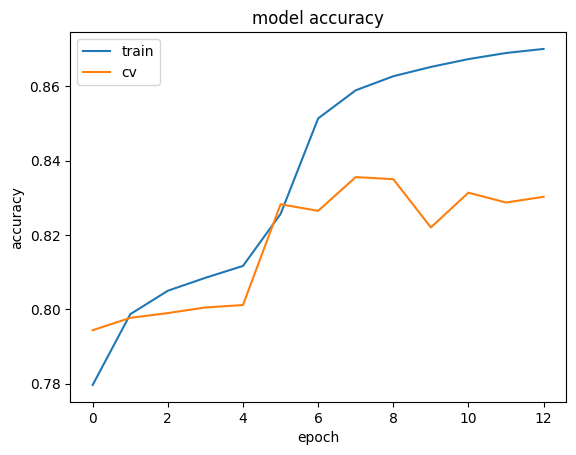

In [26]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "cv"], loc="upper left")
plt.show()

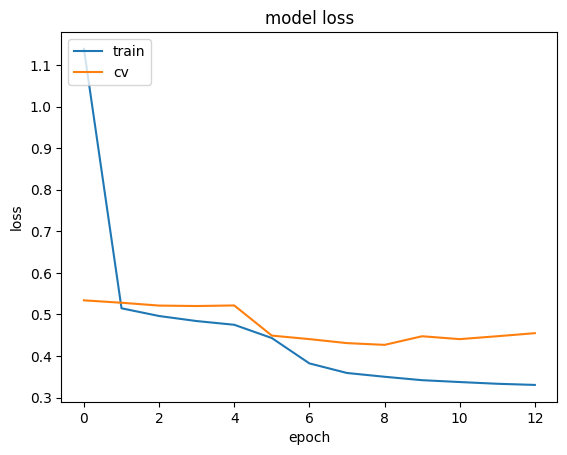

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "cv"], loc="upper left")
plt.show()

In [34]:
prob = model_lstm.predict(X_test)
y_pred = np.argmax(prob, axis=-1)

4375/4375 [==============================] - 77s 18ms/step


In [35]:
print(prob)

[[0.00542564 0.10636881 0.8882056 ]
 [0.02710488 0.96649253 0.00640262]
 [0.07377386 0.91148776 0.01473836]
 ...
 [0.16850704 0.74514794 0.08634497]
 [0.03070346 0.9681626  0.0011339 ]
 [0.02411706 0.9728354  0.00304754]]


In [36]:
y_test

array([[2.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [38]:
y_pred

array([2, 1, 1, ..., 1, 1, 1], dtype=int64)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.46      0.55     16162
         1.0       0.87      0.93      0.90    103142
         2.0       0.73      0.63      0.68     20696

    accuracy                           0.83    140000
   macro avg       0.76      0.67      0.71    140000
weighted avg       0.82      0.83      0.83    140000

